In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
import tensorflow as tf
import keras
from models import model_v1
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network

In [28]:
# dataset
from pathlib import Path
from data_generator import DataGenerator

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train"
train_gen = DataGenerator(train_path,mode="unsupervised")

# tensorflow dataset
im_shape = (train_gen.crop_size,train_gen.crop_size,3)
output_signature = ((tf.TensorSpec(shape=im_shape,dtype=tf.float32),
                     tf.TensorSpec(shape=im_shape,dtype=tf.float32)),
                     tf.TensorSpec(shape=im_shape,dtype=tf.float32)
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)

def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(8)
    return ds

train_ds = config_ds(train_ds)

(8, 128, 128, 3) (8, 128, 128, 3)
(8, 128, 128, 3)


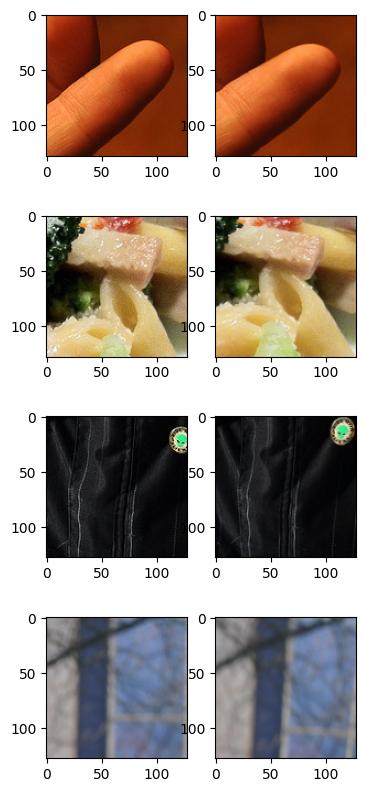

In [35]:
# plot some samples
import matplotlib.pyplot as plt
sample_input, sample_output = next(iter(train_ds))
print(sample_input[0].shape, sample_input[1].shape)
print(sample_output.shape)

plt.figure(figsize=(4,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
plt.show()

In [27]:
# build new model with TensorDLT and STN added
homography_net = model_v1()

# retrieve the input of the network
img_input = homography_net.input

# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt=homography_net.output)

# use spatial transformer to get predicted image 
img_pred = spatial_transformer_network(img_input[0],
                                       homography,
                                       img_height=img_input[0].shape[1],
                                       img_width=img_input[0].shape[2],
                                       )

full_model = keras.Model(inputs=img_input, outputs=img_pred)
full_model.summary()


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 128, 128, 3)          0         ['input_17[0][0]']            
 61 (SlicingOpLambda)                                                                             
                                                                                                  
 tf.__operators__.getitem_1  (None, 128, 128, 3)          0         ['input_18[0][0]']     

In [37]:
out1 = homography_net(sample_input)
out1.shape

TensorShape([8, 8])

In [39]:
out2 = TensorDLT(out1)
print(out2.shape)

(8, 3, 3)


In [36]:
# try calling the full model with sample input

sample_model_output = full_model(sample_input)
print(sample_model_output.shape)

InvalidArgumentError: Exception encountered when calling layer 'tf.reshape_44' (type TFOpLambda).

{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 64 values, but the requested shape has 8 [Op:Reshape]

Call arguments received by layer 'tf.reshape_44' (type TFOpLambda):
  • tensor=tf.Tensor(shape=(8, 8), dtype=float32)
  • shape=('4', '2')
  • name=None

In [19]:
# define loss function
def custom_loss_unsupervised(y_true, y_pred):
    # y_true and y_pred are now batch of images
    return tf.reduce_mean(tf.abs(y_true-y_pred,2))

# compile model

full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=custom_loss_unsupervised)

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_11')>

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_8  (None, 128, 128, 3)          0         ['input_11[0][0]']            
 1 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_8  (None, 128, 128, 3)          0         ['input_12[0][0]']      

In [23]:
full_model.output

<KerasTensor: shape=(1, 128, 128, 3) dtype=float32 (created by layer 'tf.math.add_n')>